In [1]:
import types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

PATH_REG_TRAIN = "./bitrate_prediction/bitrate_train.csv"
PATH_REG_TEST = "./bitrate_prediction/bitrate_test.csv"
PATH_CLASS_TRAIN = "./stream_quality_data/train_data.csv"
PATH_CLASS_TEST = "./stream_quality_data/test_data.csv"

x_train_c = pd.read_csv(PATH_CLASS_TRAIN)
x_test_c = pd.read_csv(PATH_CLASS_TEST)
x_train_r = pd.read_csv(PATH_REG_TRAIN)
x_test_r = pd.read_csv(PATH_REG_TEST)

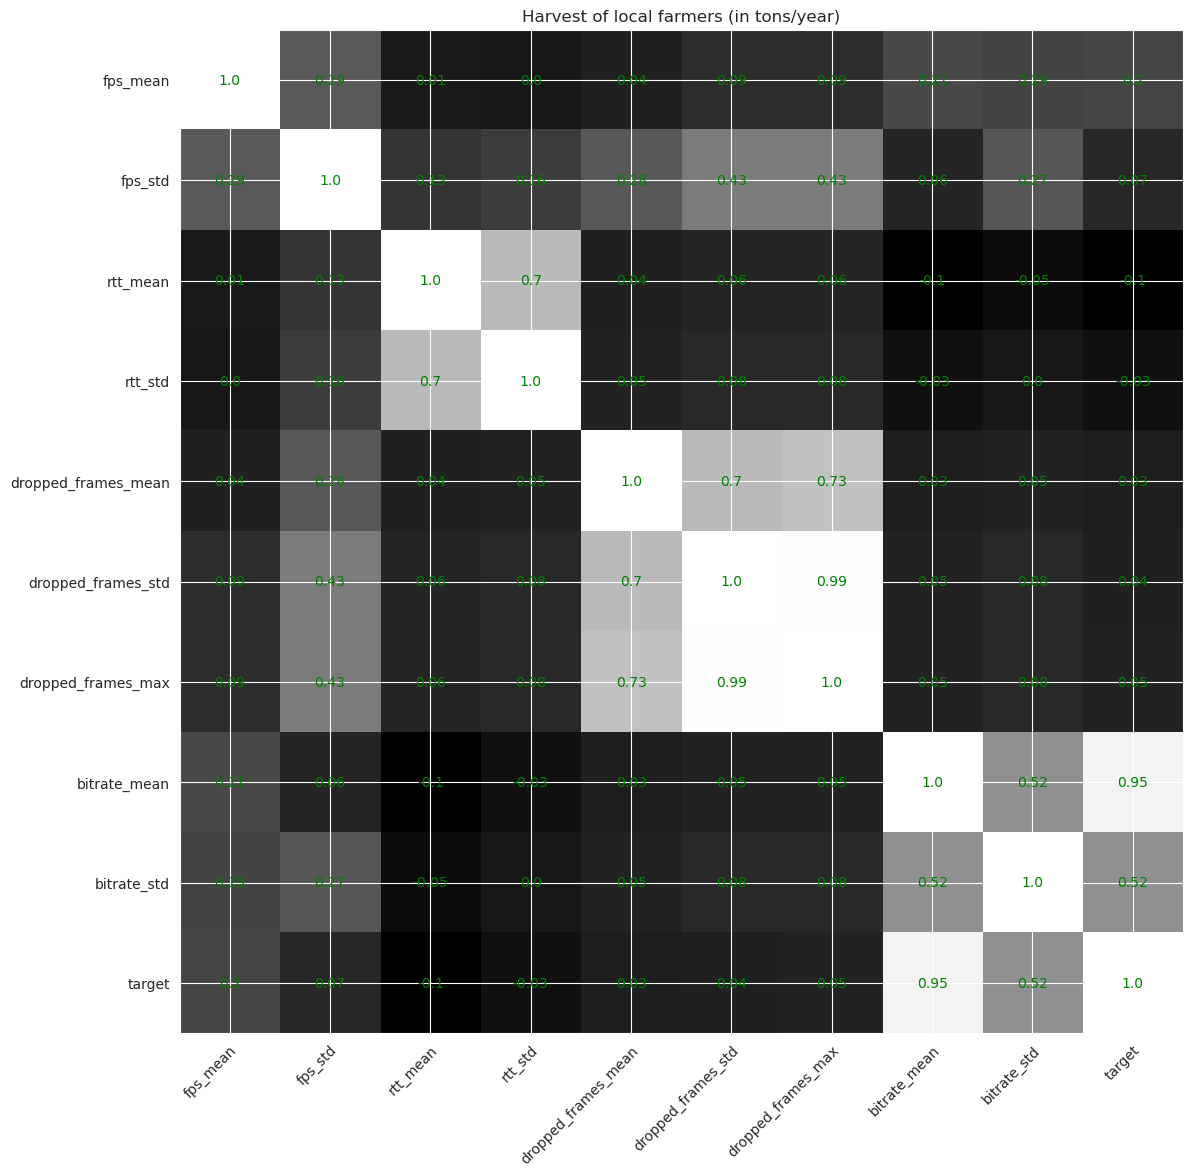

In [2]:
cols = x_train_r.columns
data = np.round(x_train_r.corr(),2)


fig, ax = plt.subplots()
fig.set_size_inches((12,12))
im = ax.imshow(data, cmap="gray")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(cols)), labels=cols)
ax.set_yticks(np.arange(len(cols)), labels=cols)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(cols)):
    for j in range(len(cols)):
        text = ax.text(j, i, data.iloc[i, j],
                       ha="center", va="center", color="green")

fig.tight_layout()
plt.show()

In [3]:
x_train_r_1 = x_train_r.drop(['dropped_frames_max', "bitrate_mean", "bitrate_std"], inplace=False, axis=1)

In [4]:
x_train_r_1.describe().T.join(pd.Series(np.sum(x_train_r_1==0, axis=0),name="Zeros"))

,count,mean,std,min,25%,50%,75%,max,Zeros
fps_mean,379021.0,35.231127,10.975010,10.0,28.800000,30.000000,43.600000,125.800000,0
fps_std,379021.0,1.725705,2.505942,0.0,0.316228,0.942809,2.233582,307.167273,92611
rtt_mean,379021.0,49.623858,94.781098,0.0,14.300000,32.200000,55.900000,12898.400000,5496
rtt_std,379021.0,12.763672,112.684460,0.0,0.699206,1.433721,4.948625,40721.933293,15520
dropped_frames_mean,379021.0,0.180451,1.732890,0.0,0.000000,0.000000,0.000000,540.000000,368604
dropped_frames_std,379021.0,0.469548,3.157866,0.0,0.000000,0.000000,0.000000,202.385770,368750
target,379021.0,7525.396231,6070.817736,0.0,2785.000000,6296.000000,10192.000000,64913.000000,320


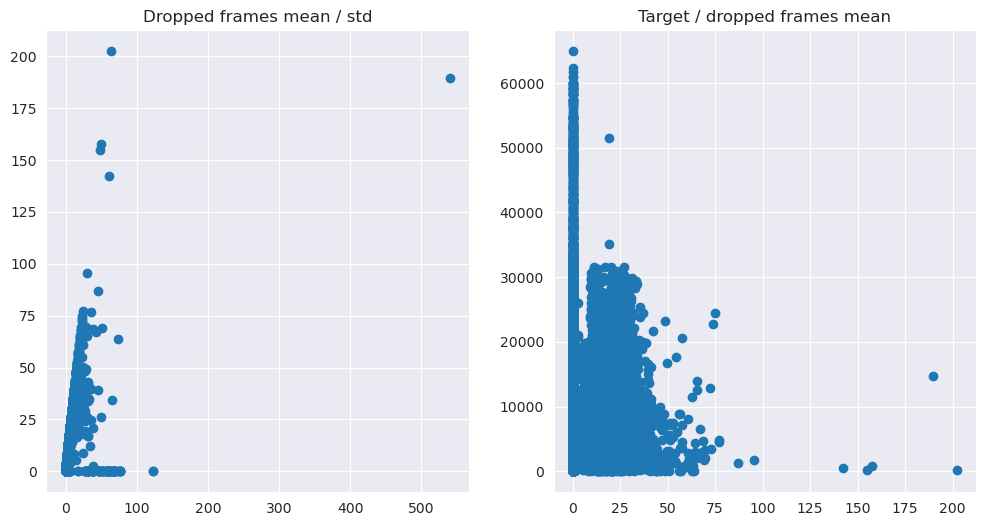

In [5]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].scatter(x_train_r_1["dropped_frames_mean"],x_train_r_1["dropped_frames_std"])
ax[0].set_title("Dropped frames mean / std")
ax[1].scatter(x_train_r_1["dropped_frames_std"], x_train_r_1["target"])
ax[1].set_title("Target / dropped frames mean")
plt.show()

(368988, 7)


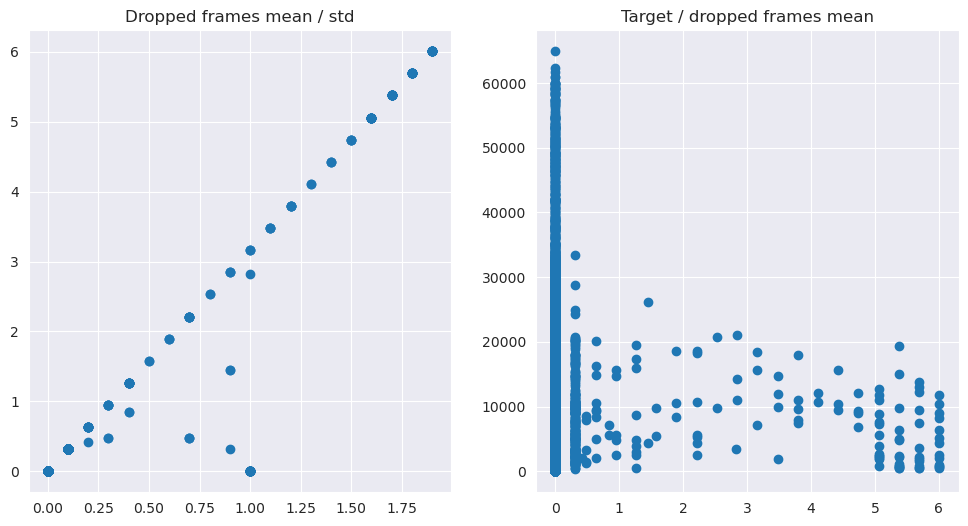

In [6]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

x_train_r_short = x_train_r_1.loc[x_train_r_1["dropped_frames_mean"] < 2]
print(x_train_r_short.shape)

ax[0].scatter(x_train_r_short["dropped_frames_mean"],x_train_r_short["dropped_frames_std"])
ax[0].set_title("Dropped frames mean / std")
ax[1].scatter(x_train_r_short["dropped_frames_std"], x_train_r_short["target"])
ax[1].set_title("Target / dropped frames mean")
plt.show()

In [7]:
(x_train_r.shape[0] - np.sum(x_train_r_1["dropped_frames_mean"].apply(lambda x: x>0) == x_train_r_1["dropped_frames_std"].apply(lambda x: x>0))) / np.sum(x_train_r_1["dropped_frames_mean"]>0)

0.014015551502351925

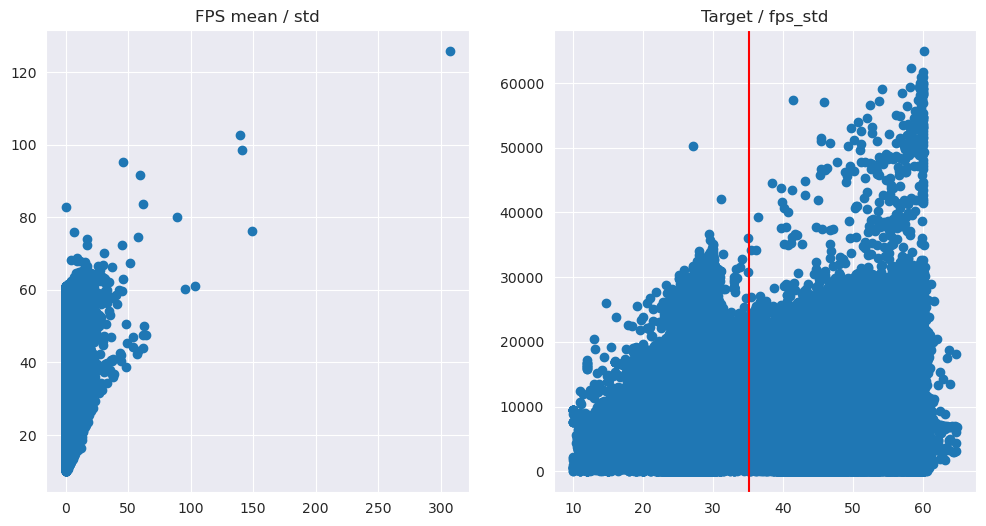

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].scatter(x_train_r_1["fps_std"],x_train_r_1["fps_mean"])
ax[0].set_title("FPS mean / std")
ax[1].scatter(x_train_r_1.loc[x_train_r_1["fps_mean"]<65]["fps_mean"], x_train_r_1.loc[x_train_r_1["fps_mean"]<65]["target"])
ax[1].set_title("Target / fps_std")
ax[1].axvline(np.mean(x_train_r_1["fps_mean"]), c="red")
plt.show()

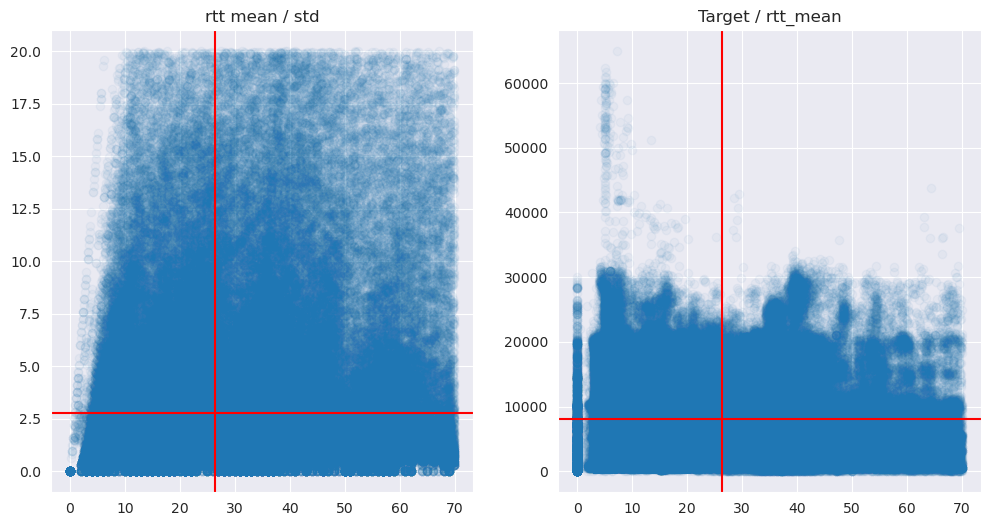

In [9]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

x_train_r_2 = x_train_r_1.loc[x_train_r_1["rtt_std"] < 20]
x_train_r_2 = x_train_r_2.loc[x_train_r_1["rtt_mean"] < 70]

ax[0].scatter(x_train_r_2["rtt_mean"],x_train_r_2["rtt_std"], alpha=0.04)
ax[0].set_title("rtt mean / std")
ax[0].axvline(np.mean(x_train_r_2["rtt_mean"]), c = 'red')
ax[0].axhline(np.mean(x_train_r_2["rtt_std"]), c = 'red')
ax[1].scatter(x_train_r_2["rtt_mean"], x_train_r_2["target"],alpha=0.04)
ax[1].set_title("Target / rtt_mean")
ax[1].axvline(np.mean(x_train_r_2["rtt_mean"]), c = 'red')
ax[1].axhline(np.mean(x_train_r_2["target"]), c = 'red')

plt.show()

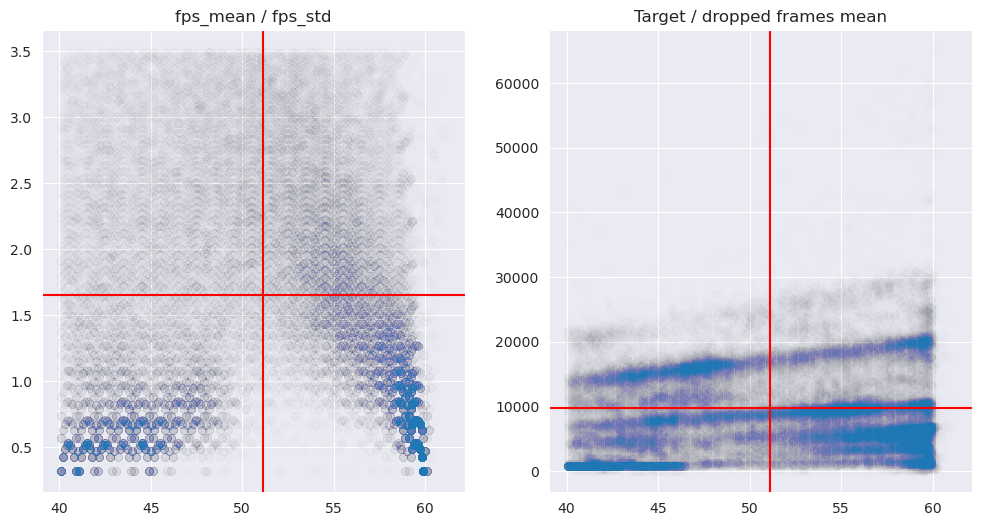

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

x_train_r_2 = x_train_r_2.loc[x_train_r_1["fps_mean"] > 40 ]
x_train_r_2 = x_train_r_2.loc[(x_train_r_2["fps_std"] < 3.5) & (x_train_r_2["fps_std"] > 0.3)]

ax[0].scatter(x_train_r_2["fps_mean"],x_train_r_2["fps_std"], alpha=0.005)
ax[0].set_title("fps_mean / fps_std")
ax[0].axvline(np.mean(x_train_r_2["fps_mean"]), c = 'red')
ax[0].axhline(np.mean(x_train_r_2["fps_std"]), c = 'red')
ax[1].scatter(x_train_r_2["fps_mean"], x_train_r_2["target"],alpha=0.005)
ax[1].set_title("Target / dropped frames mean")
ax[1].axvline(np.mean(x_train_r_2["fps_mean"]), c = 'red')
ax[1].axhline(np.mean(x_train_r_2["target"]), c = 'red')
#ax[1].scatter(x_train_r_2["fps_mean"], model.predict(x_train_r_2.drop("target", axis=1)), c = "red")

plt.show()

In [11]:
x_train_r_2.shape

(59363, 7)

In [12]:
x_train_r_1.columns

Index(['fps_mean', 'fps_std', 'rtt_mean', 'rtt_std', 'dropped_frames_mean',
       'dropped_frames_std', 'target'],
      dtype='object')

In [49]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = None
def reg_pipe(X_: pd.DataFrame, y: pd.Series = False, fit_mode = False)->pd.DataFrame:
    X = X_.copy()

    if type(y) != bool:
        X["target"] = y

    X.drop(["bitrate_mean", "bitrate_std"], inplace=True, axis=1)

    X.drop("dropped_frames_std", inplace=True, axis=1)
    X['dropped_frames_max'] = X['dropped_frames_max'].apply(lambda x: np.int8(x>0))
    #X['fps_mean'] = X['fps_mean'].apply(lambda x: min(x,22.5))

    if fit_mode:
        X.drop_duplicates(inplace = True)
        X = X.loc[X["rtt_std"] < 3.5]
        X = X.loc[X["rtt_mean"] < 55]
        X = X.loc[(X["fps_mean"] > 10)]
        X = X.loc[(X["fps_std"] < 3.5) & (X["fps_std"] > 0.3)]
        X = X.loc[(X["target"] < 21000) ]

    if "target" in X.columns:
        y = X["target"]
        X = X.drop("target", axis=1)

    global scaler
    if fit_mode:
        scaler = StandardScaler().fit(X)


    X = pd.DataFrame(scaler.transform(X), columns=X.columns)

    # X = X.apply(lambda x: x - np.mean(x), axis=1)

    if type(y) != bool:
        return X, y
    return X


In [50]:
x_train_r_no_target = x_train_r.drop(["target"], axis=1)
x_train_piped, y_train = reg_pipe(x_train_r_no_target, x_train_r["target"], fit_mode=True)

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression().fit(x_train_piped, y_train)
y_train_pred_r = model.predict(x_train_piped)
print(r2_score(y_train, y_train_pred_r))
print(np.sqrt(mean_squared_error(y_train, y_train_pred_r)))

0.06151663949706776
5178.734316697415


In [52]:
x_train_piped.describe()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_max
count,1.354640e+05,1.354640e+05,1.354640e+05,1.354640e+05,1.354640e+05,1.354640e+05
mean,3.751050e-15,-5.976754e-15,2.618213e-15,7.852759e-15,9.937366e-15,1.124873e-14
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.206115e+00,-1.096286e+00,-1.616553e+00,-1.466699e+00,-2.153257e-02,-9.187980e-02
25%,-6.928685e-01,-8.237472e-01,-8.228514e-01,-7.381684e-01,-2.153257e-02,-9.187980e-02
50%,-5.381046e-01,-2.786693e-01,-2.240942e-01,-3.429398e-01,-2.153257e-02,-9.187980e-02
75%,8.547697e-01,5.561738e-01,7.854383e-01,4.890891e-01,-2.153257e-02,-9.187980e-02
max,2.221850e+00,2.939436e+00,2.205746e+00,3.022225e+00,3.582697e+02,1.088379e+01


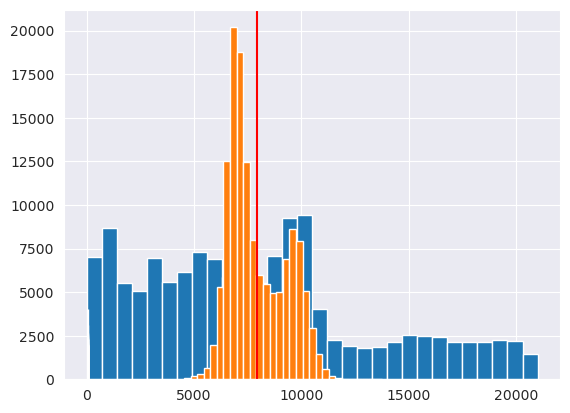

In [53]:
y_train.hist(bins=30)
pd.Series(y_train_pred_r).hist(bins=30)
x_train_r_2["fps_mean"].hist(bins=30)
plt.axvline(np.mean(y_train), c = "red")
plt.show()

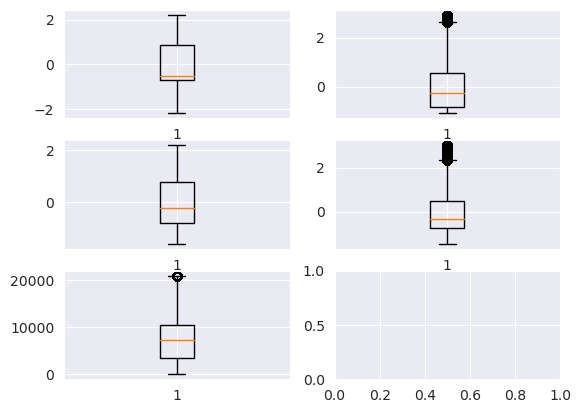

In [54]:
fg, ax = plt.subplots(3,2)

ax[0, 0].boxplot(x_train_piped["fps_mean"])
ax[0, 1].boxplot(x_train_piped["fps_std"])
ax[1, 0].boxplot(x_train_piped["rtt_mean"])
ax[1, 1].boxplot(x_train_piped["rtt_std"])
ax[2, 0].boxplot(y_train)
plt.show()

In [48]:
x_train_piped.shape

(123181, 6)

In [20]:
from pandas_profiling import ProfileReport
import yaml

report = ProfileReport(x_train_r)
report.to_file("./Profile.html")

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

/home/thornail/anaconda3/envs/ML_1/lib/python3.10/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/home/thornail/anaconda3/envs/ML_1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/thornail/anaconda3/envs/ML_1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/thornail/anaconda3/envs/ML_1/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
model.coef_

array([917.35684311, 565.68297245, -97.55930456, 261.19282515,
        24.17228079,   9.96701184])

In [22]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(x_train_piped)
X_train_pca = pca.transform(x_train_piped)

In [23]:
sorted(X_train_pca, key = lambda x: x[0], reverse=True)

[array([  6.87111894, 230.64591271]),
 array([ 3.79811217, -0.14996377]),
 array([ 3.75425939, -0.12903785]),
 array([ 3.73466111, -0.12650023]),
 array([ 3.72384744, -0.14749471]),
 array([ 3.71124912, -0.1104826 ]),
 array([ 3.70921576, -0.13409208]),
 array([ 3.70738672, -0.15912634]),
 array([ 3.68396708, -0.14125937]),
 array([ 3.66651931, -0.15074905]),
 array([ 3.65183052, -0.11388278]),
 array([ 3.62593565, -0.11299674]),
 array([ 3.59587292, -0.12301833]),
 array([ 3.59345938, -0.15846109]),
 array([ 3.59182729, -0.18867426]),
 array([ 3.57825805, -0.14841327]),
 array([ 3.57557682, -0.09657848]),
 array([ 3.56840781, -0.19288994]),
 array([ 3.56781786, -0.12318077]),
 array([ 3.54947311, -0.07301907]),
 array([ 3.53587277, -0.15508633]),
 array([ 3.53297066, -0.09001388]),
 array([ 3.53252677, -0.09021975]),
 array([ 3.52889258, -0.14816809]),
 array([ 3.52144779, -0.08416765]),
 array([ 3.50127477, -0.19720363]),
 array([ 3.50019248, -0.22137869]),
 array([ 3.49381311, -0.18

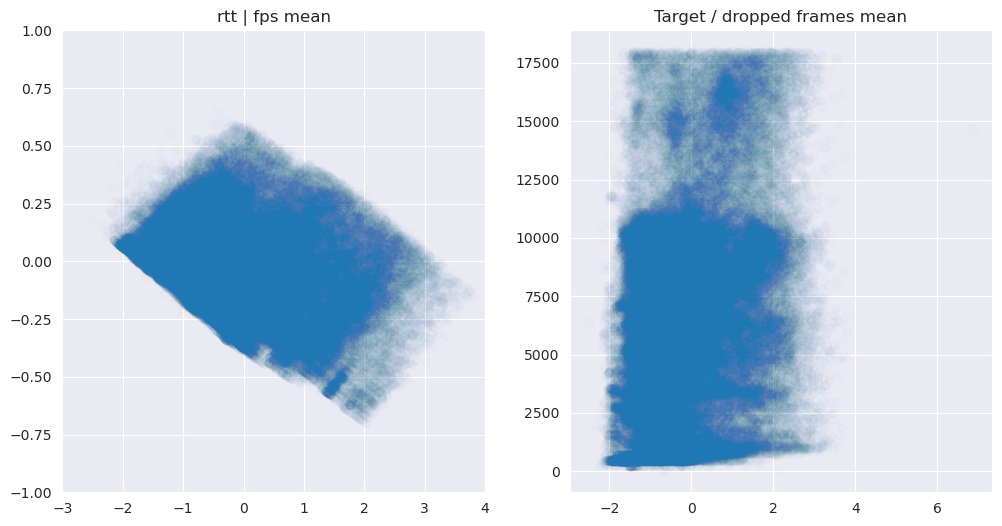

In [40]:
plt.show()
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

ax[0].scatter(X_train_pca[:,0], X_train_pca[:,1], alpha = 0.01)
ax[0].set_title("rtt | fps mean")
ax[0].set_ylim([-1, 1])
ax[0].set_xlim([-3, 4])
ax[1].scatter(X_train_pca[:,0], y_train, alpha = 0.01)
ax[1].set_title("Target / dropped frames mean")
#ax[1].set_xlim([-3, 4])
plt.show()

In [41]:
model = LinearRegression(fit_intercept=True).fit(X_train_pca, y_train)
y_train_pred_r = model.predict(X_train_pca)
print(r2_score(y_train, y_train_pred_r))

0.04928770479287159


In [26]:
model.coef_

array([881.54808501,  19.87878494])

In [38]:
x_test_r_raw = x_test_r.drop(["target", 'bitrate_mean', 'bitrate_std'], axis=1)
model_1 = LinearRegression().fit(x_test_r_raw, x_test_r["target"])
y_pred_raw = model_1.predict(x_test_r_raw)

print(np.sqrt(mean_squared_error(x_test_r["target"], y_pred_raw)))
print(r2_score(x_test_r["target"], y_pred_raw))

5787.393496857414
0.060760235339673896
